Current device is cuda:0
Loaded pretrained model
tensor([[0.9065, 0.0935]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Loaded reference
perturbation sizes: [      0       1       5      25     124     620    3095   15448   77092
  384731 1920000]
number of relevant features = 1440000
10
valid perturbations: [      0       1       5      25     124     620    3095   15448   77092
  384731 1440000]
1
5
25
124
620
3095
15448
77092
384731
1440000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


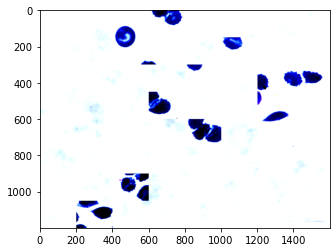

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


hexp/absolute_0: 1/107 computed perturbed logits
number of relevant features = 1650000
10
valid perturbations: [      0       1       5      25     124     620    3095   15448   77092
  384731 1650000]
1
5
25
124
620
3095
15448
77092
384731
1650000


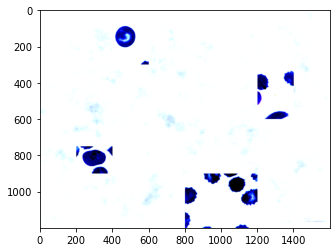

partexp: 1/107 computed perturbed logits


In [1]:
# NUMPY IMPORTS
import numpy as np

# PYTORCH IMPORTS
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms

# SYS IMPORTS
import sys
import re
import os
import time
from PIL import Image
import hshap
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

_device = "cuda:0"
device = torch.device(_device)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()
print("Current device is {}".format(device))

torch.manual_seed(0)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
weight_path = "ResNet18"
model.load_state_dict(torch.load(weight_path, map_location=device))
model = model.to(device)
model.eval()
print("Loaded pretrained model")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

data_dir = "/export/gaon1/data/jteneggi/data/malaria/trophozoite"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
_iter = iter(dataloader)
X, _ = next(_iter)
ref = X.detach().mean(0).to(device)
ref_output = model(ref.unsqueeze(0))
ref_logits = torch.nn.Softmax(dim=1)(ref_output)
print(ref_logits)
print("Loaded reference")

exp_mapper = ["hexp/absolute_0", "hexp/relative_70", "gradexp", "deepexp", "partexp", "gradcam", "gradcampp", "naive", "RDE", "lime"]

A = 1200*1600
exp_x = np.linspace(np.log10(1/A), 0, 10)
relative_perturbation_sizes = np.concatenate(([0], np.sort(10 ** (exp_x))))
perturbation_sizes = np.round(A * relative_perturbation_sizes)
perturbation_sizes = np.array(perturbation_sizes, dtype="int")
print(f"perturbation sizes: {perturbation_sizes}")
perturbations_L = len(perturbation_sizes)

true_positives_dict = np.load("true_positives.npy", allow_pickle=True).item()
true_positives = []
for c in true_positives_dict:
    for image_path in true_positives_dict[c]:
        true_positives.append(image_path)

L = len(true_positives)
for exp_name in [exp_mapper[0], exp_mapper[4]]:
    LOR_df = pd.DataFrame(columns=["exp_name", "perturbation_size", "logit"])
    explanation_dir = os.path.join("true_positive_explanations", exp_name)
    for i, image_path in enumerate(true_positives[:1]):
        image_name = os.path.basename(image_path)
        image = transform(Image.open(image_path)).to(device).detach()
        if exp_name == "naive":
            explanation = torch.rand(image.size(1), image.size(2), device=torch.device("cpu")) + .5
        else:
            explanation = np.load(os.path.join(explanation_dir, "%s.npy" % image_name))
        logits = hshap.utils.compute_perturbed_logits(model, ref, image, explanation, perturbation_sizes, normalization="original", batch_size=10)
        for j, logit in enumerate(logits):
            LOR_df = LOR_df.append({"exp_name": exp_name, "perturbation_size": logit[0], "logit": logit[1].numpy()}, ignore_index=True)
        print("%s: %d/%d computed perturbed logits" % (exp_name, i+1, L))
    LOR_df.to_csv(os.path.join("LOR", exp_name, "results.csv"))